In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/ahmedashrafahmed/alzhimer-chat-leader")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ahmedashrafahmed/alzhimer-chat-leader


100%|██████████| 1.45M/1.45M [00:01<00:00, 1.49MB/s]

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split
import keras
import numpy as np
from keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('/content/alzhimer-chat-leader/full_Chat_data.csv',usecols=[1,2])
df=df.astype(str)
# display a few random samples
df.sample(5)

,Questions,Answers
655,At what stage of Alzheimer's do people usually...,"A decreased appetite can occur at any stage, b..."
17598,Are there alternative therapies for managing A...,"Complementary therapies such as art therapy, m..."
1838,How do lifestyle factors like smoking and alco...,Smoking and excessive alcohol consumption may ...
21969,Are there any genetic factors associated with...,"Yes, APOE genotypes are associated with the r..."
20594,Are there any alternative therapies that work ...,Alternative therapies such as cognitive stimul...


In [5]:
df.shape

(25177, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25177 entries, 0 to 25176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  25177 non-null  object
 1   Answers    25177 non-null  object
dtypes: object(2)
memory usage: 393.5+ KB


In [7]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Questions'].tolist() + df['Answers'].tolist())

vocab_size = len(tokenizer.word_index) + 1

In [8]:
vocab_size

10578

In [9]:
# Convert text to sequences
questions_sequences = tokenizer.texts_to_sequences(df['Questions'].tolist())
answers_sequences = tokenizer.texts_to_sequences(df['Answers'].tolist())

In [10]:
questions_sequences[:5]

[[23, 12, 54, 8],
 [23, 452, 3, 8],
 [23, 17, 2, 51, 4, 3, 8],
 [12, 3, 8, 2, 2117, 5597, 22, 67],
 [15, 214, 12, 3, 8]]

In [11]:
# Pad sequences
max_seq_length = 350
questions_padded = pad_sequences(questions_sequences, maxlen=max_seq_length, padding='post')
answers_padded = pad_sequences(answers_sequences, maxlen=max_seq_length, padding='post')

In [12]:
questions_padded

array([[ 23,  12,  54, ...,   0,   0,   0],
       [ 23, 452,   3, ...,   0,   0,   0],
       [ 23,  17,   2, ...,   0,   0,   0],
       ...,
       [ 15,  12,   3, ...,   0,   0,   0],
       [ 17,  32, 182, ...,   0,   0,   0],
       [ 15,   7,   3, ...,   0,   0,   0]], dtype=int32)

In [13]:
answers_padded

array([[  54,    8,   12, ...,    0,    0,    0],
       [   2, 6245,  452, ...,    0,    0,    0],
       [  89,  300,    1, ...,    0,    0,    0],
       ...,
       [ 191,  337,  941, ...,    0,    0,    0],
       [  44,  180,   38, ...,    0,    0,    0],
       [ 119,    9,  134, ...,    0,    0,    0]], dtype=int32)

In [14]:
# Prepare the targets
answers_padded = np.expand_dims(answers_padded, -1)  # Keras expects targets to be in the format (samples, timesteps, features)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(questions_padded, answers_padded, test_size=0.05, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (23918, 350)
X_test shape is  (1259, 350)
y_train shape is  (23918, 350, 1)
y_test shape is  (1259, 350, 1)


In [16]:
# Parameters
embedding_dim = 128
latent_dim = 128

# Encoder
encoder_inputs = Input(shape=(max_seq_length,))
encoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_seq_length)(encoder_inputs)
encoder_lstm = LSTM(latent_dim)(encoder_embedding)

# Decoder
decoder_inputs = RepeatVector(max_seq_length)(encoder_lstm)
decoder_lstm = LSTM(latent_dim, return_sequences=True)(decoder_inputs)
decoder_outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_lstm)

# Autoencoder
autoencoder = Model(encoder_inputs, decoder_outputs)

In [17]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350)]             0         
                                                                 
 embedding (Embedding)       (None, 350, 128)          1353984   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 repeat_vector (RepeatVecto  (None, 350, 128)          0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 350, 128)          131584    
                                                                 
 time_distributed (TimeDist  (None, 350, 10578)        1364562   
 ributed)                                                    

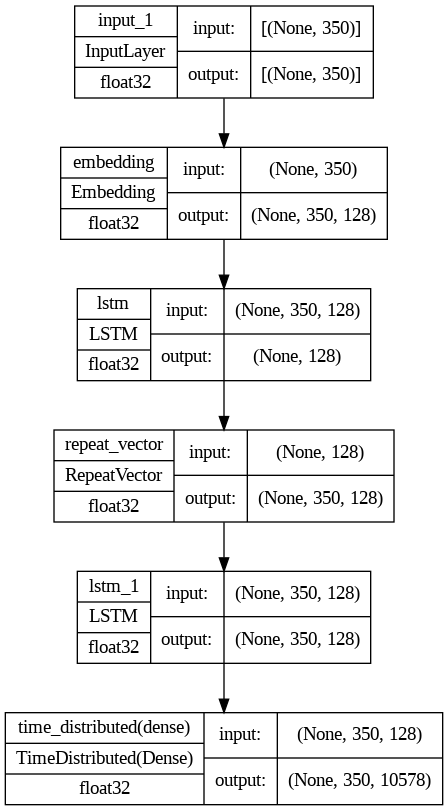

In [18]:
keras.utils.plot_model(autoencoder,show_shapes=True, show_dtype=True, show_layer_names=True)

In [19]:
autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc'])
checkpoint_cb =ModelCheckpoint("model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
hist = autoencoder.fit(X_train,y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
337/337 [==============================] - 41s 105ms/step - loss: 1.3229 - acc: 0.8968 - val_loss: 0.7265 - val_acc: 0.9021
Epoch 2/50
337/337 [==============================] - 29s 87ms/step - loss: 0.7438 - acc: 0.8997 - val_loss: 0.7136 - val_acc: 0.9029
Epoch 3/50
337/337 [==============================] - 28s 84ms/step - loss: 0.7368 - acc: 0.9004 - val_loss: 0.7105 - val_acc: 0.9034
Epoch 4/50
337/337 [==============================] - 28s 83ms/step - loss: 0.7323 - acc: 0.9009 - val_loss: 0.7061 - val_acc: 0.9038
Epoch 5/50
337/337 [==============================] - 28s 83ms/step - loss: 0.7298 - acc: 0.9011 - val_loss: 0.7047 - val_acc: 0.9038
Epoch 6/50
337/337 [==============================] - 28s 83ms/step - loss: 0.7290 - acc: 0.9011 - val_loss: 0.7036 - val_acc: 0.9038
Epoch 7/50
337/337 [==============================] - 28s 84ms/step - loss: 0.7274 - acc: 0.9012 - val_loss: 0.7030 - val_acc: 0.9038
Epoch 8/50
337/337 [==============================] - 28s 84m

In [20]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,acc,val_loss,val_acc
0,1.322855,0.896796,0.726491,0.902108
1,0.743751,0.899661,0.713640,0.902863
2,0.736765,0.900426,0.710458,0.903354
3,0.732267,0.900867,0.706088,0.903826
4,0.729792,0.901077,0.704737,0.903795
5,0.729010,0.901115,0.703645,0.903826
6,0.727353,0.901164,0.702963,0.903831
7,0.726259,0.901168,0.702255,0.903844
8,0.726077,0.901178,0.702608,0.903835
9,0.725087,0.901190,0.701802,0.903893


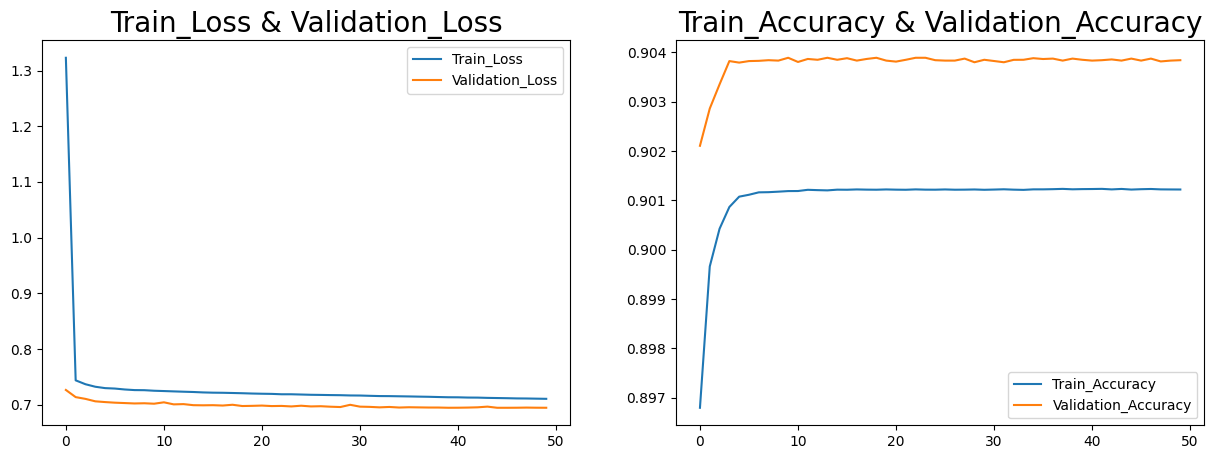

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['acc'],label='Train_Accuracy')
plt.plot(hist_['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [29]:
score,acc = autoencoder.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

40/40 [==============================] - 1s 27ms/step - loss: 0.7150 - acc: 0.9016
Test Loss = 0.7150313854217529
Test Accuracy = 0.901645302772522
